## Which Debts Are Worth the Bank's Effort?
Play bank data scientist and use regression discontinuity to see which debts are worth collecting.

### Project Description

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.

Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.

<img src="https://www.unz.com/wp-content/uploads/2018/01/shutterstock_791528089.jpg" title="Bank Debts collectable Analysis" />

In [1]:
# Import required modules for project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder


In [2]:
# Load the dataset into a DataFrame
data = pd.read_csv("bank_data.csv")

In [3]:
data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [4]:
(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1882 non-null   int64  
 1   expected_recovery_amount  1882 non-null   int64  
 2   actual_recovery_amount    1882 non-null   float64
 3   recovery_strategy         1882 non-null   object 
 4   age                       1882 non-null   int64  
 5   sex                       1882 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


In [5]:
# Summary statistics
print(data.describe())

                id  expected_recovery_amount  actual_recovery_amount  \
count  1882.000000               1882.000000             1882.000000   
mean   1035.596174               2759.967588             4000.967837   
std     591.458429               2019.826565             4576.506350   
min       6.000000                194.000000              200.425000   
25%     534.250000               1261.250000             1045.190300   
50%    1029.500000               2062.000000             2115.446373   
75%    1551.750000               3569.500000             5417.237207   
max    2056.000000               9964.000000            34398.479710   

               age  
count  1882.000000  
mean     39.650372  
std      15.453072  
min      18.000000  
25%      28.000000  
50%      35.000000  
75%      50.000000  
max      84.000000  


In [6]:
#checking null values in the dataset
data.isnull().sum()

id                          0
expected_recovery_amount    0
actual_recovery_amount      0
recovery_strategy           0
age                         0
sex                         0
dtype: int64

In [7]:
#data types of all columns
data.dtypes

id                            int64
expected_recovery_amount      int64
actual_recovery_amount      float64
recovery_strategy            object
age                           int64
sex                          object
dtype: object

In [8]:
data.recovery_strategy.head(10)

0    Level 0 Recovery
1    Level 0 Recovery
2    Level 0 Recovery
3    Level 0 Recovery
4    Level 0 Recovery
5    Level 0 Recovery
6    Level 0 Recovery
7    Level 0 Recovery
8    Level 0 Recovery
9    Level 0 Recovery
Name: recovery_strategy, dtype: object

In [9]:
data.sex.head(10)

0      Male
1    Female
2      Male
3      Male
4      Male
5      Male
6      Male
7    Female
8    Female
9      Male
Name: sex, dtype: object

In [10]:
data.recovery_strategy.tail()

1877    Level 4 Recovery
1878    Level 4 Recovery
1879    Level 4 Recovery
1880    Level 4 Recovery
1881    Level 4 Recovery
Name: recovery_strategy, dtype: object

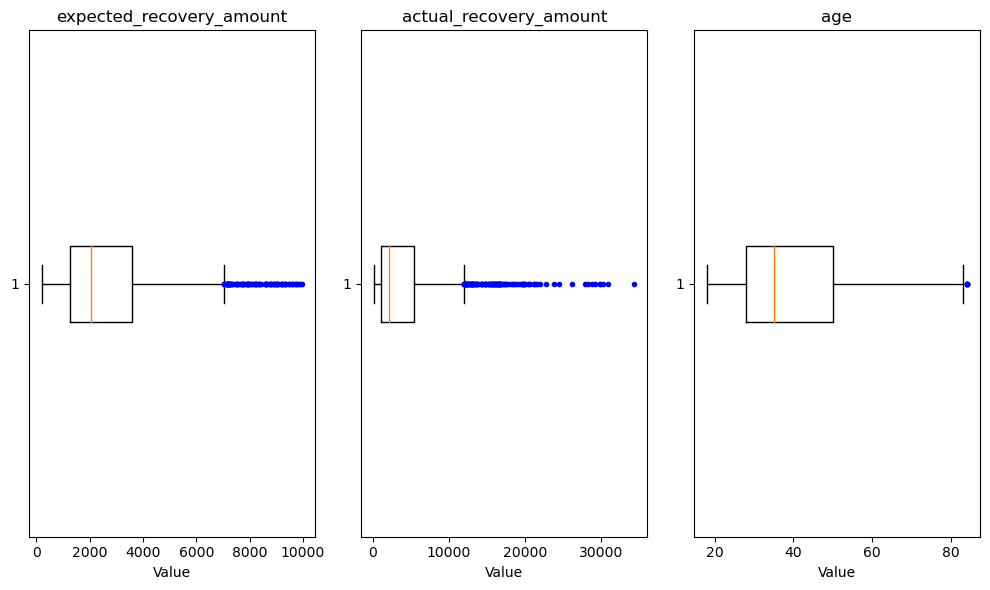

In [11]:
# Define the numerical columns to check for outliers
numerical_columns = ['expected_recovery_amount', 'actual_recovery_amount', 'age']

# Create a box plot for each numerical column
plt.figure(figsize=(10, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, len(numerical_columns), i)
    plt.boxplot(data[column], vert=False, sym='b.')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('')

plt.tight_layout()
plt.show()

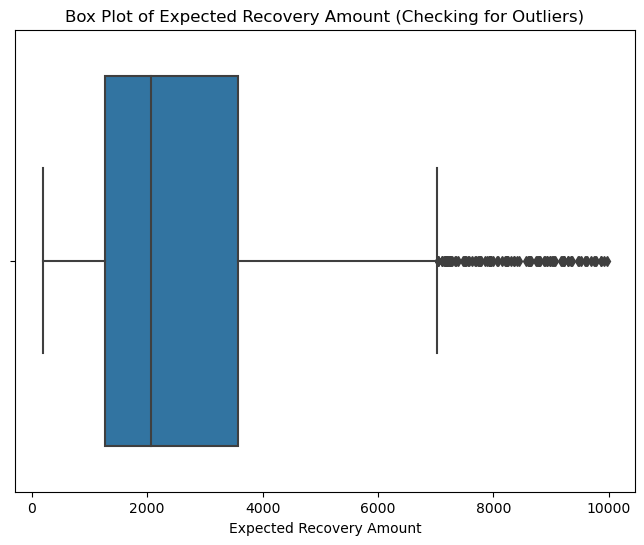

In [12]:
# Create a box plot to check for outliers in the Expected Recovery Amount
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['expected_recovery_amount'])

# Add labels and title
plt.xlabel('Expected Recovery Amount')
plt.title('Box Plot of Expected Recovery Amount (Checking for Outliers)')

# Show the plot
plt.show()

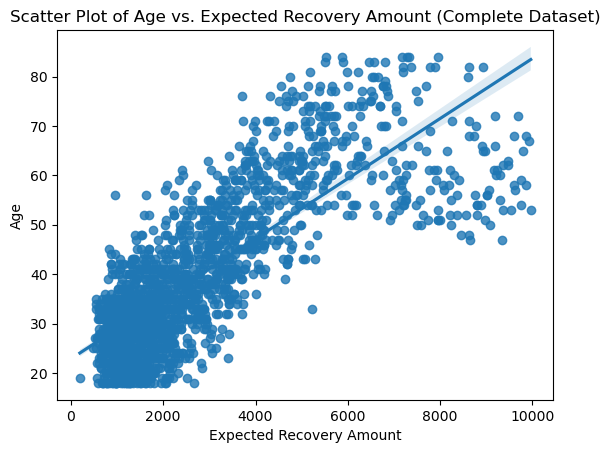

In [13]:
# Create a regression plot of Age vs. Expected Recovery Amount for the complete dataset
sns.regplot(x='expected_recovery_amount', y='age', data=data)

# Add labels and title
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.title('Scatter Plot of Age vs. Expected Recovery Amount (Complete Dataset)')

# Show the plot
plt.show()

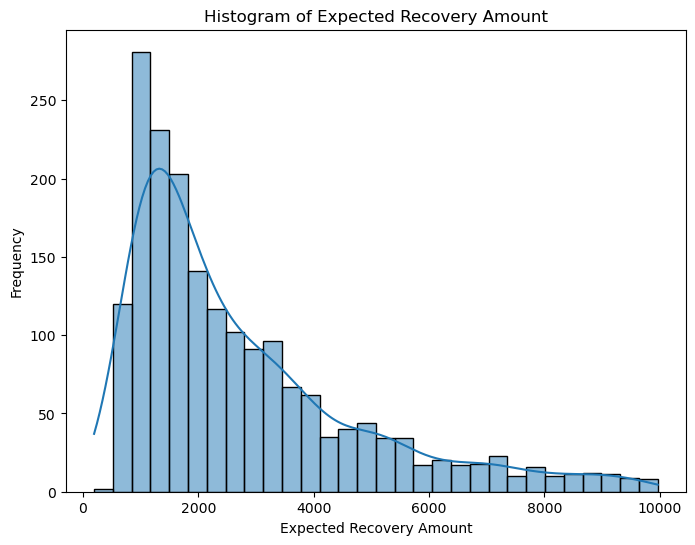

In [14]:
# Create a histogram of Expected Recovery Amount
plt.figure(figsize=(8, 6))
sns.histplot(data['expected_recovery_amount'], bins=30, kde=True)

# Add labels and title
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Recovery Amount')

# Show the plot
plt.show()

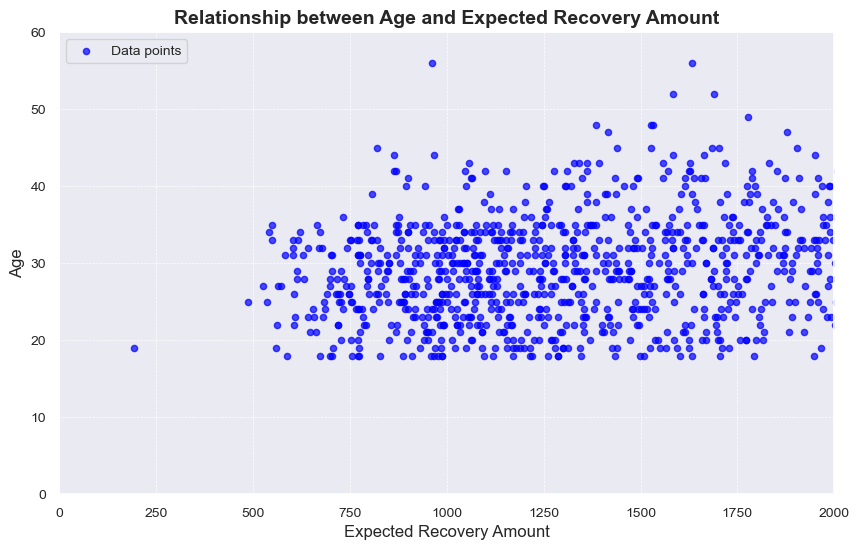

In [15]:
# Set the style for the plot
sns.set(style="darkgrid")

# Scatter plot of Age vs. Expected Recovery Amount
plt.figure(figsize=(10, 6))
plt.scatter(x=data['expected_recovery_amount'], y=data['age'], color="blue", marker="o", s=20, alpha=0.7, label="Data points")
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.title("Relationship between Age and Expected Recovery Amount", fontsize=14, fontweight="bold")
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Statistical test: age vs. expected recovery amount


In [16]:
# Define the range from $900 to $1100
range_900_to_1100 = (data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] < 1100)

# Select the data just below and just above the threshold
data_analysis = data[range_900_to_1100]

# Compute average age just below and above the threshold by recovery strategy
average_age_by_recovery_strategy = data_analysis.groupby('recovery_strategy')['age'].mean()

# Display the average age by recovery strategy
print("Average Age by Recovery Strategy:")
print(average_age_by_recovery_strategy)

# Perform Kruskal-Wallis test
Level_0_age = data_analysis[data_analysis['recovery_strategy'] == 'Level 0 Recovery']['age']
Level_1_age = data_analysis[data_analysis['recovery_strategy'] == 'Level 1 Recovery']['age']
kw_statistic, p_value = stats.kruskal(Level_0_age, Level_1_age)

# Print the results of the Kruskal-Wallis test
print("\nKruskal-Wallis Test:")
print("Kruskal-Wallis Statistic:", kw_statistic)
print("P-Value:", p_value)

Average Age by Recovery Strategy:
recovery_strategy
Level 0 Recovery    27.224719
Level 1 Recovery    28.755319
Name: age, dtype: float64

Kruskal-Wallis Test:
Kruskal-Wallis Statistic: 3.4572342749517513
P-Value: 0.06297556896097407


### Statistical test: sex vs. expected recovery amount


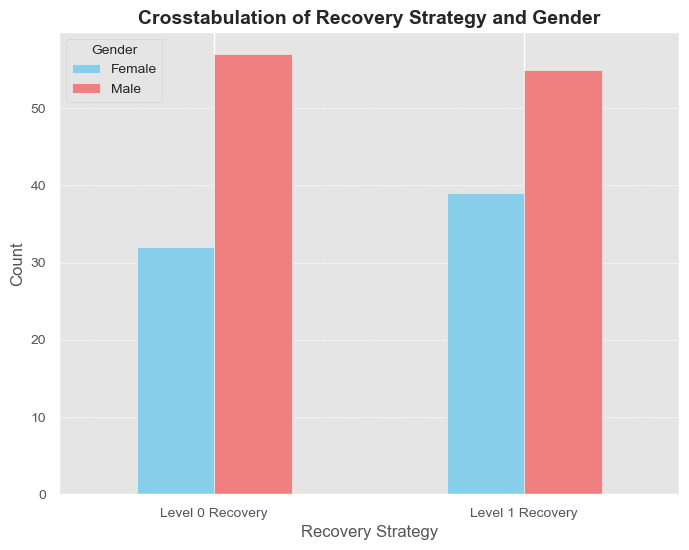

***********************************************
Calculation: sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
P-Value: 0.5377947810444592
***********************************************


In [17]:

# Filter the data within the range $900 to $1100
data_filtered = data[(data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] < 1100)]

# Create a crosstabulation of recovery strategy and gender
crosstab = pd.crosstab(data_filtered['recovery_strategy'], data_filtered['sex'])

# Perform the chi-square test
chi2_stat, p_val, dof, ex = chi2_contingency(crosstab)

# Set the style for the plot
plt.style.use('ggplot')

# Create a bar plot of the crosstabulation
crosstab.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral'])
plt.xlabel('Recovery Strategy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Crosstabulation of Recovery Strategy and Gender', fontsize=14, fontweight='bold')
plt.legend(title='Gender', fontsize=10, title_fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Print the results

print("***********************************************")
print("Calculation:",crosstab)
print("P-Value:", p_val)
print("***********************************************")

### Exploratory graphical analysis: recovery amount

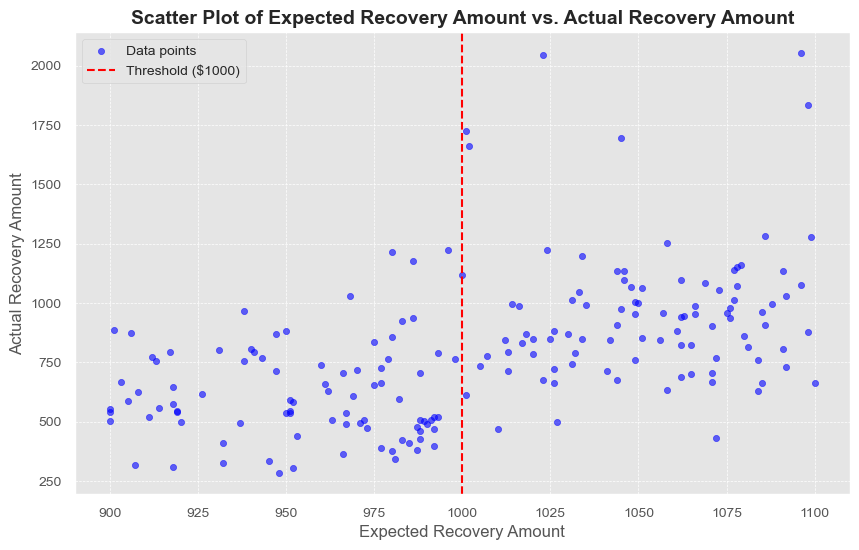

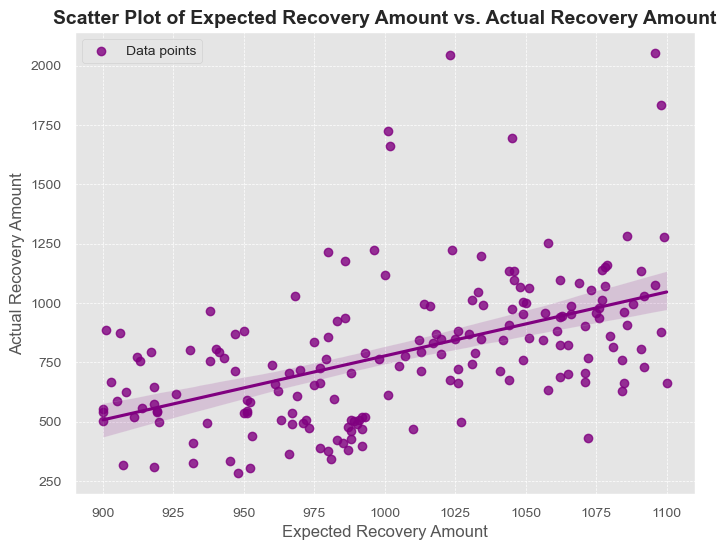

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

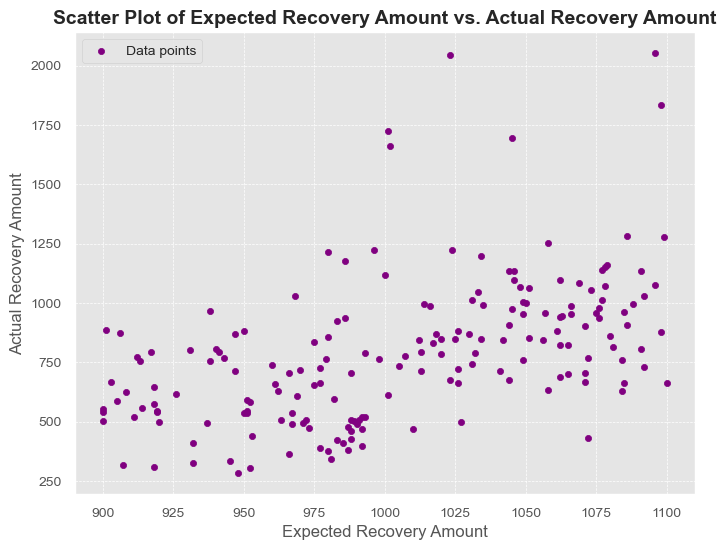

In [18]:
# Define the range from $900 to $1100
era_900_1100 = data[(data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] <= 1100)]

# Scatter plot of Expected Recovery Amount vs. Actual Recovery Amount
plt.figure(figsize=(10, 6))
plt.scatter(x=era_900_1100['expected_recovery_amount'], y=era_900_1100['actual_recovery_amount'], color='blue', marker='o', s=20, alpha=0.6, label='Data points')
plt.axvline(x=1000, color='red', linestyle='--', label='Threshold ($1000)')
plt.xlabel('Expected Recovery Amount', fontsize=12)
plt.ylabel('Actual Recovery Amount', fontsize=12)
plt.title('Scatter Plot of Expected Recovery Amount vs. Actual Recovery Amount', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plot the regression plot of Expected Recovery Amount vs. Actual Recovery Amount

plt.figure(figsize=(8, 6))
sns.regplot(x=era_900_1100['expected_recovery_amount'], y=era_900_1100['actual_recovery_amount'], color='purple', marker='o', label='Data points')
plt.xlabel('Expected Recovery Amount', fontsize=12)
plt.ylabel('Actual Recovery Amount', fontsize=12)
plt.title('Scatter Plot of Expected Recovery Amount vs. Actual Recovery Amount', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Plot the scatter plot of Expected Recovery Amount vs. Actual Recovery Amount

plt.figure(figsize=(8, 6))
plt.scatter(x=era_900_1100['expected_recovery_amount'], y=era_900_1100['actual_recovery_amount'], color='purple', marker='o', s=20, label='Data points')
plt.xlabel('Expected Recovery Amount', fontsize=12)
plt.ylabel('Actual Recovery Amount', fontsize=12)
plt.title('Scatter Plot of Expected Recovery Amount vs. Actual Recovery Amount', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.show()



### Statistical analysis: recovery amount

Average Actual Recovery Amount:
recovery_strategy
Level 0 Recovery    623.017022
Level 1 Recovery    952.750603
Name: actual_recovery_amount, dtype: float64

Kruskal-Wallis Test - $900 to $1100 Range:
Kruskal-Wallis Statistic: 64.89840778685254
P-Value: 7.886077128395961e-16

Average Actual Recovery Amount - $950 to $1050 Range:
recovery_strategy
Level 0 Recovery    626.140273
Level 1 Recovery    947.035496
Name: actual_recovery_amount, dtype: float64

Kruskal-Wallis Test - $950 to $1050 Range:
Kruskal-Wallis Statistic: 30.246000000000038
P-Value: 3.80575314300276e-08


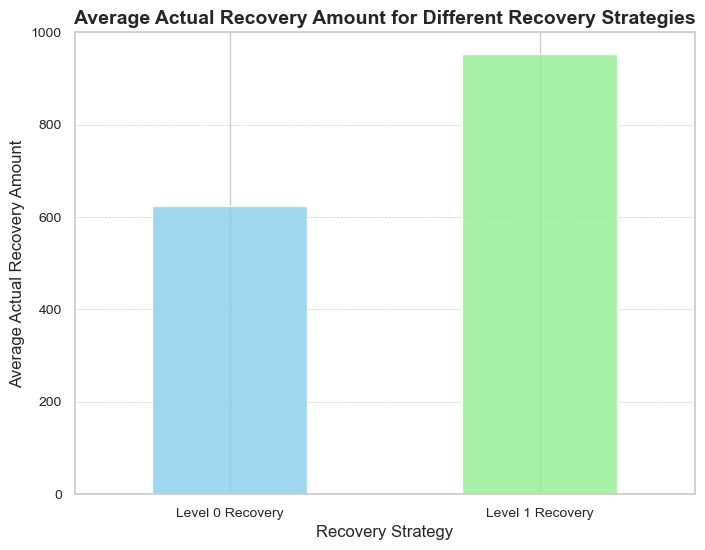

In [19]:
#Statistical analysis: recovery amount

# Set the style for the plot
sns.set(style="whitegrid")

# Define the range from $900 to $1100
era_900_1100 = data[(data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] <= 1100)]

# Compute average actual recovery amount just below and above the threshold
average_actual_recovery = era_900_1100.groupby('recovery_strategy')['actual_recovery_amount'].mean()

# Display the average actual recovery amount just below and above the threshold
print("Average Actual Recovery Amount:")
print(average_actual_recovery)

# Perform Kruskal-Wallis test for the range of $900 to $1100
Level_0_actual = era_900_1100[era_900_1100['recovery_strategy'] == 'Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100[era_900_1100['recovery_strategy'] == 'Level 1 Recovery']['actual_recovery_amount']
kw_statistic_1, p_value_1 = stats.kruskal(Level_0_actual, Level_1_actual)

# Print the Kruskal-Wallis test results
print("\nKruskal-Wallis Test - $900 to $1100 Range:")
print("Kruskal-Wallis Statistic:", kw_statistic_1)
print("P-Value:", p_value_1)

# Repeat for a smaller range of $950 to $1050
era_950_1050 = data[(data['expected_recovery_amount'] < 1050) & (data['expected_recovery_amount'] >= 950)]

# Compute average actual recovery amount just below and above the threshold for the new range
average_actual_recovery_new_range = era_950_1050.groupby('recovery_strategy')['actual_recovery_amount'].mean()

# Display the average actual recovery amount just below and above the threshold for the new range
print("\nAverage Actual Recovery Amount - $950 to $1050 Range:")
print(average_actual_recovery_new_range)

# Perform Kruskal-Wallis test for the range of $950 to $1050
Level_0_actual_new_range = era_950_1050[era_950_1050['recovery_strategy'] == 'Level 0 Recovery']['actual_recovery_amount']
Level_1_actual_new_range = era_950_1050[era_950_1050['recovery_strategy'] == 'Level 1 Recovery']['actual_recovery_amount']
kw_statistic_2, p_value_2 = stats.kruskal(Level_0_actual_new_range, Level_1_actual_new_range)

# Print the Kruskal-Wallis test results for the new range
print("\nKruskal-Wallis Test - $950 to $1050 Range:")
print("Kruskal-Wallis Statistic:", kw_statistic_2)
print("P-Value:", p_value_2)

# Create a bar chart to visualize average actual recovery amount for different recovery strategies
plt.figure(figsize=(8, 6))
average_actual_recovery.plot(kind='bar', color=['skyblue', 'lightgreen'], alpha=0.8)
plt.xlabel('Recovery Strategy', fontsize=12)
plt.ylabel('Average Actual Recovery Amount', fontsize=12)
plt.title('Average Actual Recovery Amount for Different Recovery Strategies', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

### Regression modeling: no threshold


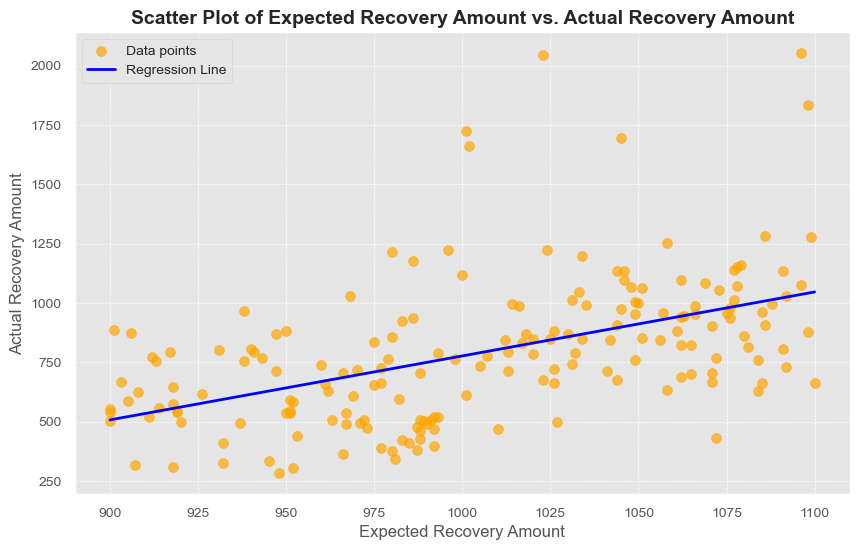

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.253
Model:                                OLS   Adj. R-squared:                  0.248
Method:                     Least Squares   F-statistic:                     61.48
Date:                    Sun, 23 Jul 2023   Prob (F-statistic):           3.65e-13
Time:                            19:35:53   Log-Likelihood:                -1286.5
No. Observations:                     184   AIC:                             2577.
Df Residuals:                         182   BIC:                             2583.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [20]:
# Define the range from $900 to $1100
range_900_to_1100 = (data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] <= 1100)

# Select the data just below and just above the threshold
data_analysis = data[range_900_to_1100]

# Define X and y for the linear regression model
X = data_analysis['expected_recovery_amount']
y = data_analysis['actual_recovery_amount']

# Add a constant term to X for the intercept in the regression model
X = sm.add_constant(X)

# Build the linear regression model
model = sm.OLS(y, X).fit()

# Get predictions from the model
predictions = model.predict(X)

# Set the style for the plot
plt.style.use('ggplot')

# Plot the scatter plot of Expected Recovery Amount vs. Actual Recovery Amount
plt.figure(figsize=(10, 6))
plt.scatter(X['expected_recovery_amount'], y, color='orange', marker='o', s=50, alpha=0.7, label='Data points')
plt.plot(X['expected_recovery_amount'], predictions, color='blue', linewidth=2, label='Regression Line')
plt.xlabel('Expected Recovery Amount', fontsize=12)
plt.ylabel('Actual Recovery Amount', fontsize=12)
plt.title('Scatter Plot of Expected Recovery Amount vs. Actual Recovery Amount', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Print out the model summary statistics
print(model.summary())

### Regression modeling: adding true threshold


                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.309
Model:                                OLS   Adj. R-squared:                  0.301
Method:                     Least Squares   F-statistic:                     40.43
Date:                    Sun, 23 Jul 2023   Prob (F-statistic):           3.06e-15
Time:                            19:35:57   Log-Likelihood:                -1279.3
No. Observations:                     184   AIC:                             2565.
Df Residuals:                         181   BIC:                             2574.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

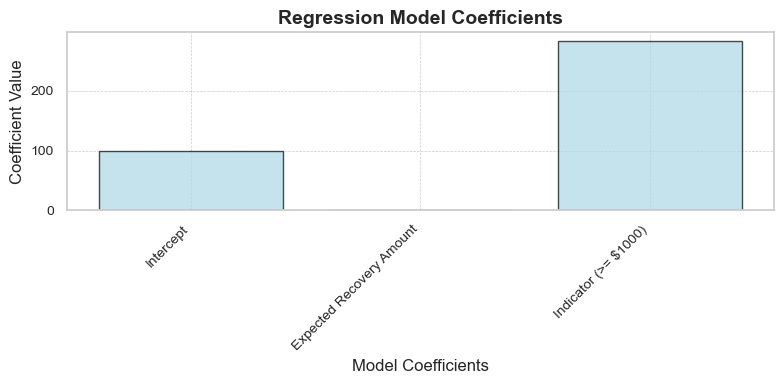

In [21]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
data['above_threshold'] = np.where(data['expected_recovery_amount'] >= 1000, 1, 0)

# Define the window for analysis (expected recovery amounts between $900 and $1100)
window_lower = 900
window_upper = 1100
window_data = data[(data['expected_recovery_amount'] >= window_lower) & 
                   (data['expected_recovery_amount'] <= window_upper)]

# Define X and y for the regression model
X = window_data[['expected_recovery_amount', 'above_threshold']]
y = window_data['actual_recovery_amount']
X = sm.add_constant(X)

# Build the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Set the style for the plot
sns.set(style="whitegrid")

# Show the model coefficients as a bar chart
coef_names = ['Intercept', 'Expected Recovery Amount', 'Indicator (>= $1000)']
coef_values = model.params.values
plt.figure(figsize=(8, 4))
plt.bar(coef_names, coef_values, color='lightblue', edgecolor='black', alpha=0.7)
plt.xlabel('Model Coefficients', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Regression Model Coefficients', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

### Regression modeling: adjusting the window


In [24]:

# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = data.loc[(data['expected_recovery_amount'] < 1050) & 
                        (data['expected_recovery_amount'] >= 950)]

# Create indicator (0 or 1) for expected recovery amount >= $1000
era_950_1050['indicator_1000'] = (era_950_1050['expected_recovery_amount'] >= 1000).astype(int)

# Define X and y for the regression model
X = era_950_1050[['expected_recovery_amount', 'indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Set the style for the plot
sns.set(style="whitegrid")

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Sun, 23 Jul 2023   Prob (F-statistic):           1.12e-07
Time:                            19:36:22   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

C:\Users\XGBoost\AppData\Local\Temp\ipykernel_4232\2842176807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era_950_1050['indicator_1000'] = (era_950_1050['expected_recovery_amount'] >= 1000).astype(int)


### Comparison of above two windows in a visualization

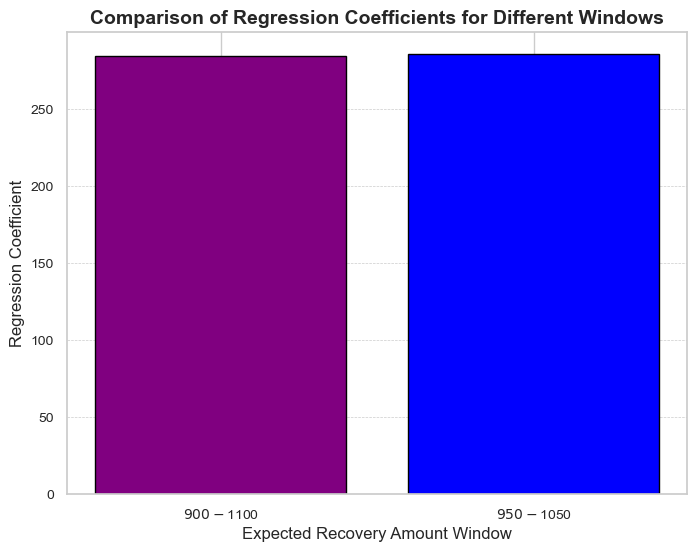

In [25]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
data['above_threshold'] = np.where(data['expected_recovery_amount'] >= 1000, 1, 0)

# Define the first window for analysis (expected recovery amounts between $900 and $1100)
window_lower1 = 900
window_upper1 = 1100
window_data1 = data[(data['expected_recovery_amount'] >= window_lower1) & 
                    (data['expected_recovery_amount'] <= window_upper1)]

# Define X and y for the first regression model
X1 = window_data1[['expected_recovery_amount', 'above_threshold']]
y1 = window_data1['actual_recovery_amount']
X1 = sm.add_constant(X1)

# Build the first linear regression model
model1 = sm.OLS(y1, X1).fit()

# Get the regression coefficient for the true threshold in the first window
coeff1 = model1.params['above_threshold']

# Define the second window for analysis (expected recovery amounts between $950 and $1050)
window_lower2 = 950
window_upper2 = 1050
window_data2 = data[(data['expected_recovery_amount'] >= window_lower2) & 
                    (data['expected_recovery_amount'] <= window_upper2)]

# Define X and y for the second regression model
X2 = window_data2[['expected_recovery_amount', 'above_threshold']]
y2 = window_data2['actual_recovery_amount']
X2 = sm.add_constant(X2)

# Build the second linear regression model
model2 = sm.OLS(y2, X2).fit()

# Get the regression coefficient for the true threshold in the second window
coeff2 = model2.params['above_threshold']

# Visualize the comparison of regression coefficients using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['$900-$1100', '$950-$1050'], [coeff1, coeff2], color=['purple', 'blue'], edgecolor='black')
plt.xlabel('Expected Recovery Amount Window', fontsize=12)
plt.ylabel('Regression Coefficient', fontsize=12)
plt.title('Comparison of Regression Coefficients for Different Windows', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Findings and Decisions

`After analyzing the data, I wanted to determine which level of the higher recovery strategy would be most effective. The higher recovery strategy is a way for the bank to collect more money from customers who owe debts. The bank assigns different recovery strategies based on how much money they expect to recover from the customer.`

`The main question was whether the higher recovery strategy, which involves more effort and costs, actually leads to more money being recovered compared to the lower level. To find out, I focused on the transition from Level 0 to Level 1, which happens at the 1000 dollars threshold.`

`Through my analysis, I found that the higher recovery strategy had a significant impact. On average, customers just above and just below the 1000 dollar threshold paid around 278 dollars more than those at the lower level. This means that the higher recovery strategy was effective in encouraging customers to pay more.`

`Considering the additional cost of implementing the higher strategy, which is 50 dollars per customer, the extra 278 dollars recovered shows that the strategy is not only effective but also financially beneficial for the bank. It's worth the extra cost because it brings in much more money.`

**So finally, I determined that Level 1, which covers customers with expected recovery amounts between 1001 dollars and 2000 dollars, is the best level for implementing the higher recovery strategy. This approach is expected to significantly increase the amount of money recovered from customers in this range, making it a valuable and worthwhile strategy for the bank's debt collection efforts.**